# Electricity Load Forecast

> In this example we will show how to perform electricity load forecasting using MLForecast alongside many models. We also compare them against the prophet library.

## Introduction

Some time series are generated from very low frequency data. These data generally exhibit multiple seasonalities. For example, hourly data may exhibit repeated patterns every hour (every 24 observations) or every day (every 24 * 7, hours per day, observations). This is the case for electricity load. Electricity load may vary hourly, e.g., during the evenings electricity consumption may be expected to increase. But also, the electricity load varies by week. Perhaps on weekends there is an increase in electrical activity.


In this example we will show how to model the two seasonalities of the time series to generate accurate forecasts in a short time. We will use hourly PJM electricity load data. The original data can be found [here](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption). 

## Libraries

In this example we will use the following libraries:


- [`mlforecast`](https://nixtla.github.io/mlforecast/). Accurate and ⚡️ fast forecasting withc lassical machine learning models. 
- [`prophet`](https://github.com/facebook/prophet). Benchmark model developed by Facebook.
- [`utilsforecast`](https://nixtla.github.io/utilsforecast/). Library with different functions for forecasting evaluation.

If you have already installed the libraries you can skip the next  cell, if not be sure to run it.

In [1]:
# %%capture
# !pip install prophet
# !pip install -U mlforecast
# !pip install -U utilsforecast

## Forecast using Multiple Seasonalities

### Electricity Load Data

According to the [dataset's page](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption),

> PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. The hourly power consumption data comes from PJM's website and are in megawatts (MW).

Let's take a look to the data.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(10, 8))
plt.rc("font", size=10)

In [3]:
data_url = 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv'
df = pd.read_csv(data_url)
df.columns = ['ds', 'y']
df.insert(0, 'unique_id', 'PJM_Load_hourly')
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
print(f'Shape of the data {df.shape}')
df.tail()

Shape of the data (32896, 3)


,unique_id,ds,y
32891,PJM_Load_hourly,2001-12-31 20:00:00,36392.0
32892,PJM_Load_hourly,2001-12-31 21:00:00,35082.0
32893,PJM_Load_hourly,2001-12-31 22:00:00,33890.0
32894,PJM_Load_hourly,2001-12-31 23:00:00,32590.0
32895,PJM_Load_hourly,2002-01-01 00:00:00,31569.0


<AxesSubplot: xlabel='ds'>

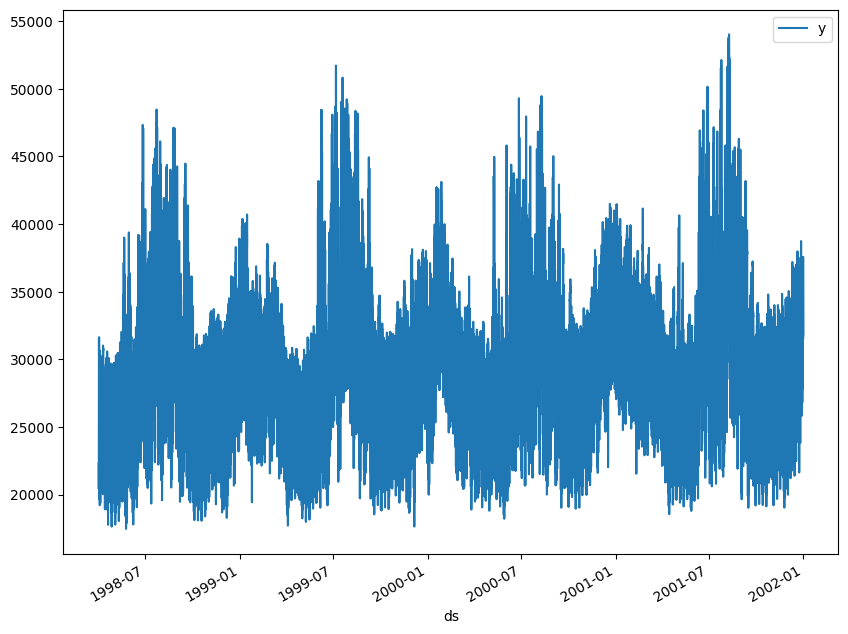

In [4]:
df.plot(x='ds', y='y')

We clearly observe that the time series exhibits seasonal patterns. Moreover, the time series contains `32,896` observations, so it is necessary to use very computationally efficient methods to display them in production.

We are going to split our series in order to create a train and test set. The model will be tested using the last 24 hours of the timeseries.

In [5]:
threshold_time = df['ds'].max() - pd.Timedelta(hours=24)

# Split the dataframe
df_train = df[df['ds'] <= threshold_time]
df_last_24_hours = df[df['ds'] > threshold_time]

### Analizing Seasonalities

First we must visualize the seasonalities of the model. As mentioned before, the electricity load presents seasonalities every 24 hours (Hourly) and every 24 * 7 (Daily) hours. Therefore, we will use `[24, 24 * 7]` as the seasonalities for the model. In order to analize how they affect our series we are going to use the `Difference` method.

In [6]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

We can use the `MLForecast.preprocess` method to explore different transformations. It looks like these series have a strong seasonality on the hour of the day, so we can subtract the value from the same hour in the previous day to remove it. This can be done with the `mlforecast.target_transforms.Differences` transformer, which we pass through `target_transforms`.  
  

In order to analize the trends individually and combined we are going to plot them individually and combined. Therefore, we can compare them against the original series. We can use the next function for that.

In [8]:
def plot_differences(df, differences,fname):
    prep = [df]
    # Plot individual Differences
    for d in differences:
        fcst = MLForecast(
        models=[],  # we're not interested in modeling yet
        freq='H',  # our series have hourly frequency 
        target_transforms=[Differences([d])],
        )
        df_ = fcst.preprocess(df)
        df_['unique_id'] = df_['unique_id'] + f'_{d}'
        prep.append(df_)
        
    # Plot combined Differences
    fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq='H',  # our series have hourly frequency 
    target_transforms=[Differences([24, 24*7])],
    )
    df_ = fcst.preprocess(df)
    df_['unique_id'] = df_['unique_id'] + f'_all_diff'
    prep.append(df_)
    prep = pd.concat(prep, ignore_index=True)
    #return prep
    n_series = len(prep['unique_id'].unique())
    fig, ax = plt.subplots(nrows=n_series, figsize=(7 * n_series, 10*n_series), squeeze=False)
    for title, axi in zip(prep['unique_id'].unique(), ax.flat):
        df_ = prep[prep['unique_id'] == title]
        df_.set_index('ds')['y'].plot(title=title, ax=axi)
    fig.savefig(f'../figs/{fname}', bbox_inches='tight')
    plt.show()
    plt.close()

Since the seasonalities are present at `24` hours (daily) and `24*7` (weekly) we are going to substract them from the serie using `Differences([24, 24*7])` and plot them.

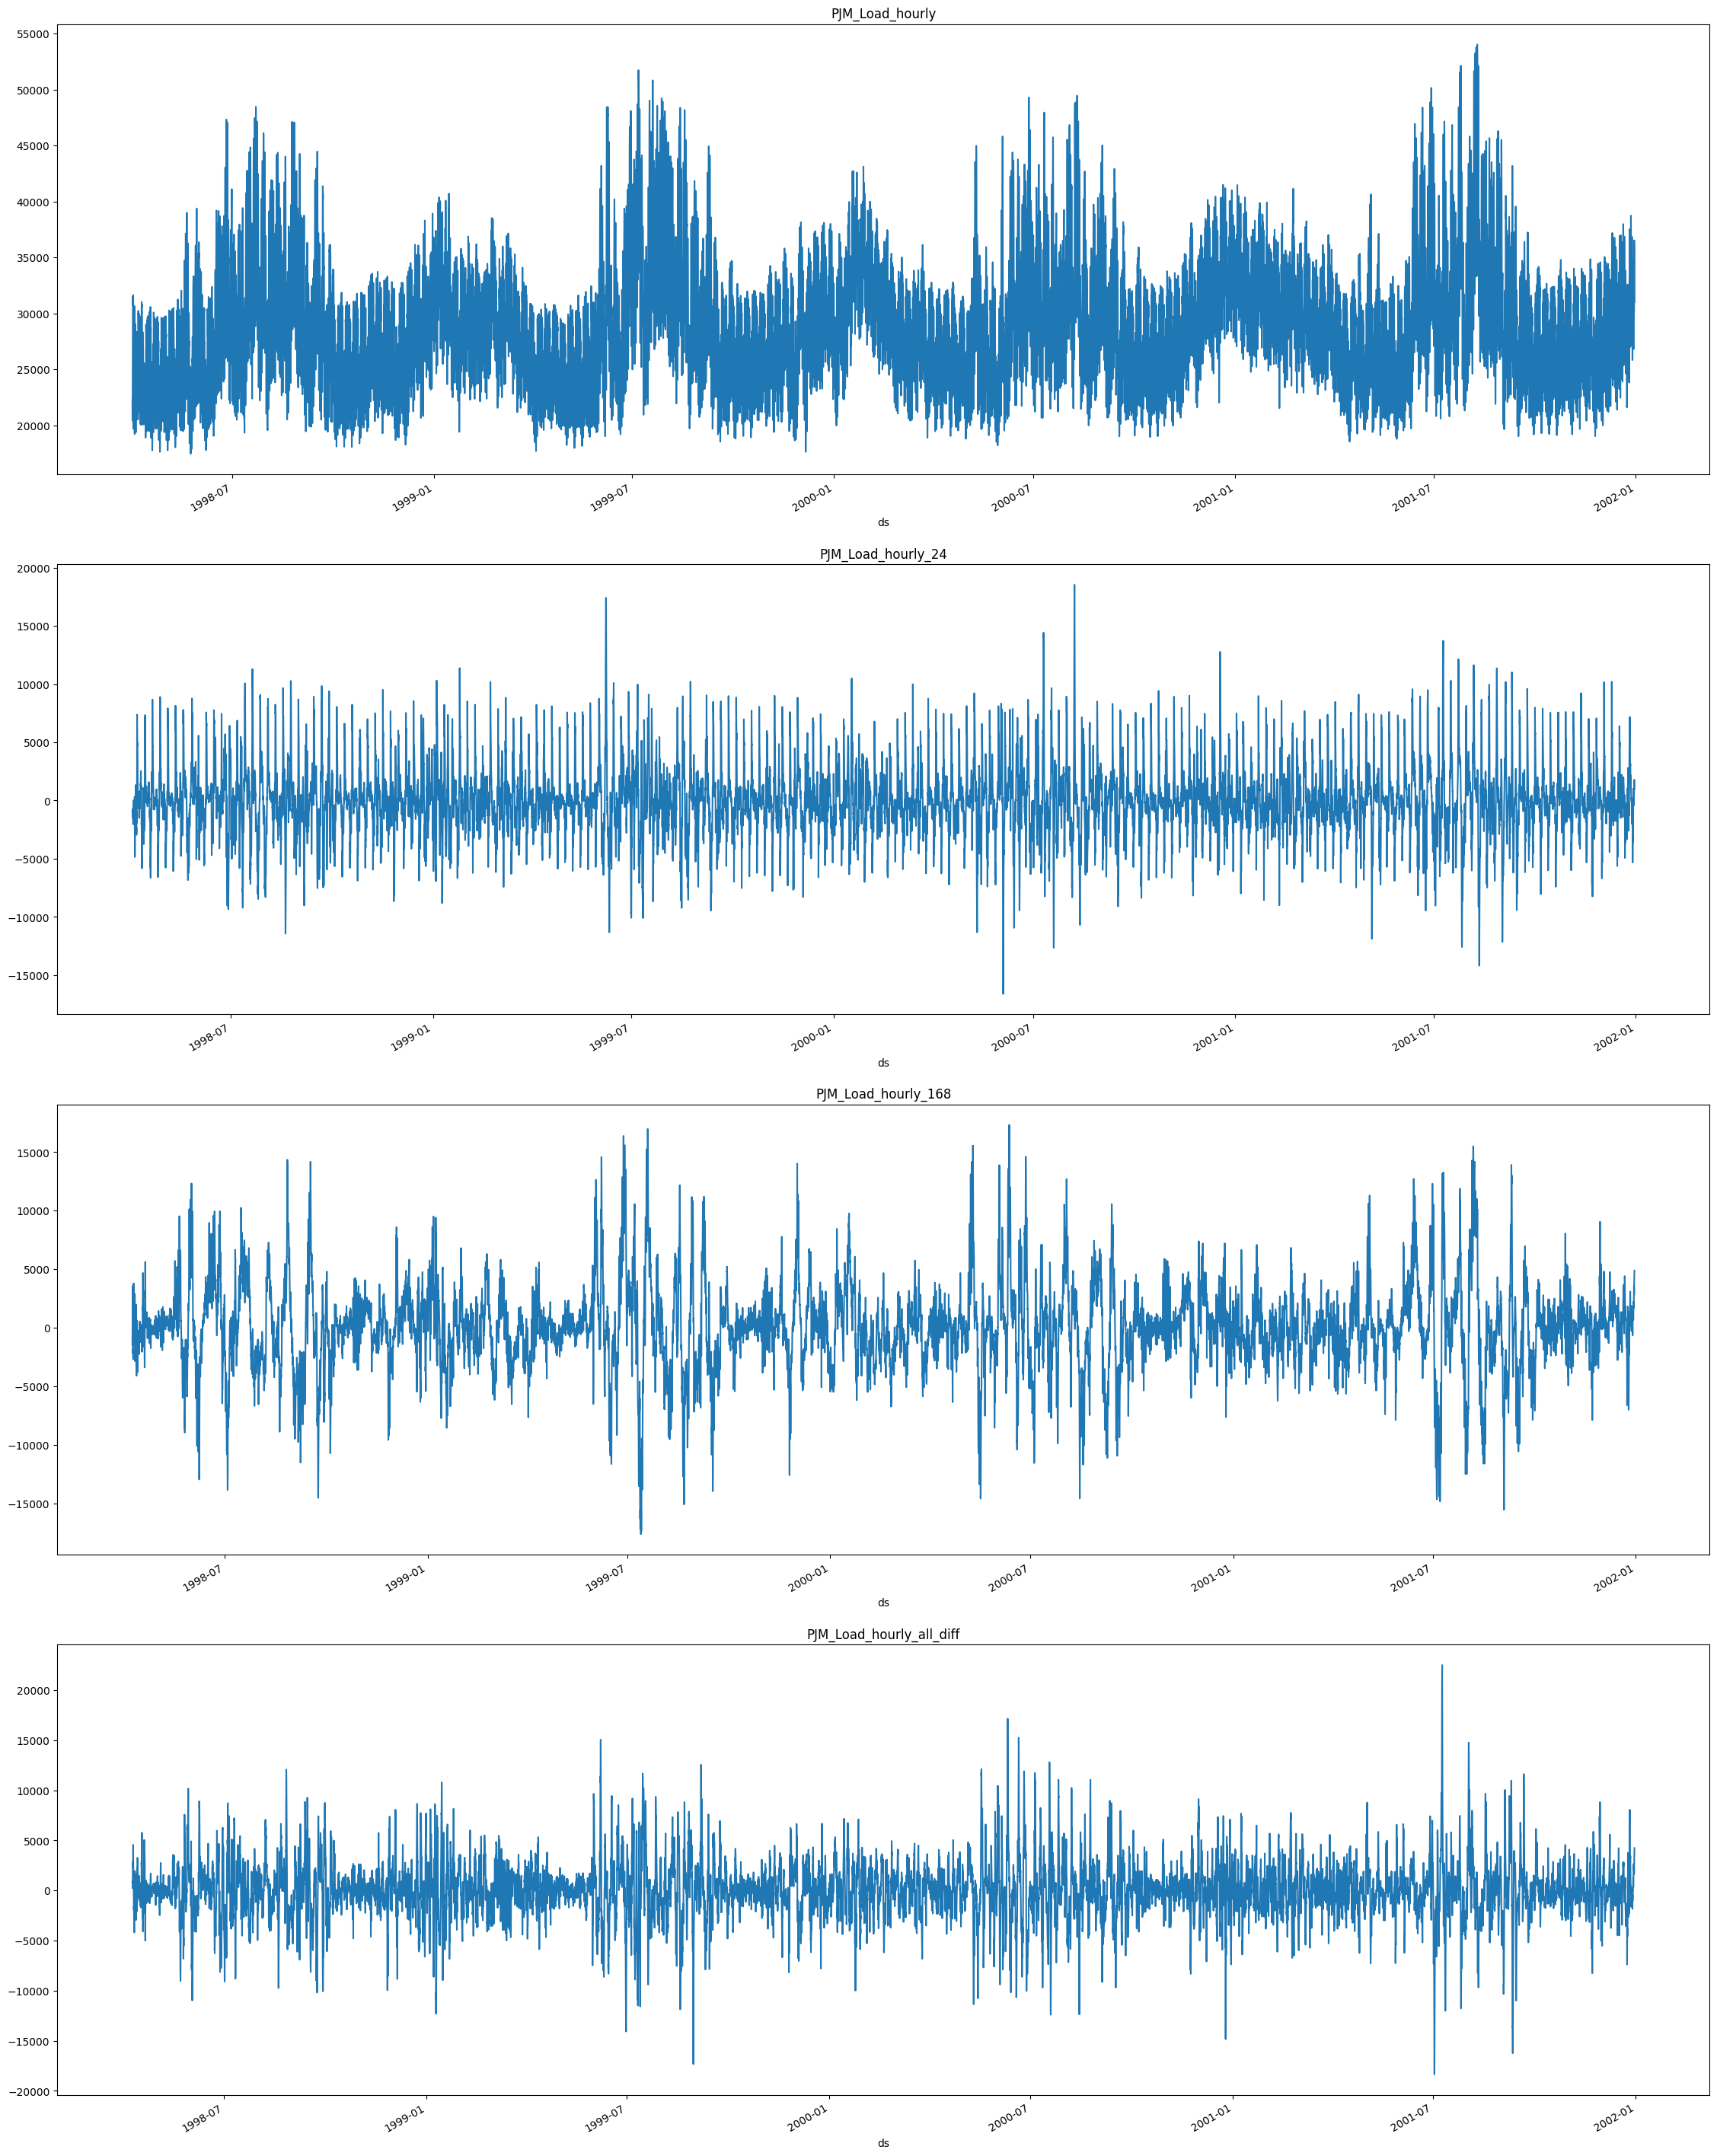

In [9]:
plot_differences(df=df_train, differences=[24, 24*7], fname='load_forecasting__differences.png')

As we can see when we extract the 24 difference (daily) in `PJM_Load_hourly_24` the series seem to stabilize sisnce the peaks seem more uniform in comparison with the original series `PJM_Load_hourly`.

When we extrac the 24*7 (weekly) `PJM_Load_hourly_168` difference we can see there is more periodicity in the peaks in comparison with the original series.    

Finally we can see the result from the combined result from substracting all the differences `PJM_Load_hourly_all_diff`.

For modeling we are going to use both difference for the forecasting, therefore we are setting the argument `target_transforms` from the `MLForecast` object equal to `[Differences([24, 24*7])]`, if we wanted to include a yearly difference we would need to add the term `24*365`.

In [10]:
fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq='H',  # our series have hourly frequency 
    target_transforms=[Differences([24, 24*7])],
)
prep = fcst.preprocess(df_train)
prep

,unique_id,ds,y
192,PJM_Load_hourly,1998-04-09 02:00:00,831.0
193,PJM_Load_hourly,1998-04-09 03:00:00,918.0
194,PJM_Load_hourly,1998-04-09 04:00:00,760.0
195,PJM_Load_hourly,1998-04-09 05:00:00,849.0
196,PJM_Load_hourly,1998-04-09 06:00:00,710.0
...,...,...,...
32867,PJM_Load_hourly,2001-12-30 20:00:00,3417.0
32868,PJM_Load_hourly,2001-12-30 21:00:00,3596.0
32869,PJM_Load_hourly,2001-12-30 22:00:00,3501.0
32870,PJM_Load_hourly,2001-12-30 23:00:00,3939.0


<AxesSubplot: xlabel='ds'>

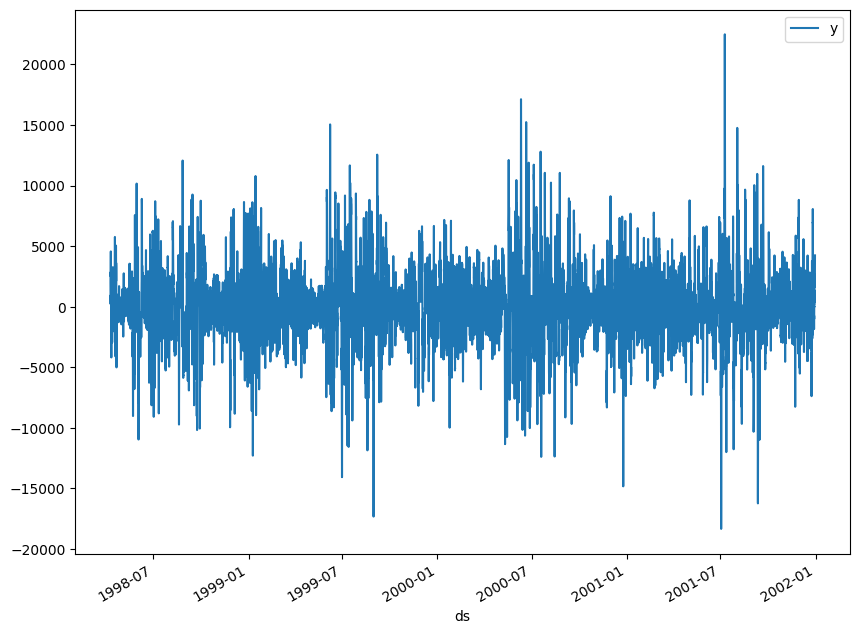

In [11]:
prep.plot(x='ds', y='y')

### Model Selection with Cross-Validation

We can test many models simoultaneously using MLForecast `cross_validation`. We can import `lightgbm` and `scikit-learn` models and try different combinations of them, alongside different target transformations (as the ones we created previously) and historical variables.  
You can see an in-depth tutorial on how to use `MLForecast` [Cross Validation methods here](https://nixtla.github.io/mlforecast/docs/cross_validation.html)

In [12]:
import lightgbm as lgb
from mlforecast.target_transforms import Differences
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

We can create a benchmark `Naive` model that uses the electricity load of the last hour as prediction `lag1` as showed in the next cell. You can create your own models and try them with `MLForecast` using the same structure.

In [13]:
class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

Now let's try differen models from the `scikit-learn` library: `Lasso`, `LinearRegression`, `Ridge`, `KNN`, `MLP` and `Random Forest` alongside the `LightGBM`. You can add any model to the dictionary to train and compare them by adding them to the dictionary (`models`) as shown.

In [14]:
# Model dictionary
models ={
        'naive': Naive(),
        'lgbm': lgb.LGBMRegressor(),
        'lasso': Lasso(),
        'lin_reg': LinearRegression(),
        'ridge': Ridge(),
        'knn': KNeighborsRegressor(),
        'mlp': MLPRegressor(), 
        'rf': RandomForestRegressor()
    }


The we can instanciate the `MLForecast` class with the models we want to try along side `target_transforms`, `lags`, `lag_transforms`, and `date_features`.  All this features are applied to the models we selected.


In this case we use the 1st, 12th and 24th lag, which are passed as a list. Potentially you could pass a `range`.
```
lags=[1,12,24]
```


Lag transforms are defined as a dictionary where the keys are the lags and the values are lists of functions that transform an array. These must be [numba](http://numba.pydata.org/) jitted functions (so that computing the features doesn’t become a bottleneck). There are some implemented in the [window-ops](https://github.com/jmoralez/window_ops) package but you can also implement your own.  
For this example we applied an expanding mean to the first lag, and a rolling mean to the 24th lag.  
```
    lag_transforms={  
            1: [expanding_mean],
            24: [(rolling_mean, 48)],
        }
```

For using the date features you need to be sure that your time column is made of timestamps. Then it might make sense to extract features like week, dayofweek, quarter, etc. You can do that by passing a list of strings with [pandas time/date components](https://pandas.pydata.org/docs/user_guide/timeseries.html#time-date-components). You can also pass functions that will take the time column as input, as we’ll show here.  
Here we add month, hour and dayofweek features:
```
    date_features=['month', 'hour', 'dayofweek']

```

In [15]:
mlf = MLForecast(
    models = models, 
    freq='H',  # our series have hourly frequency 
    target_transforms=[Differences([24, 24*7])],
    lags=[1,12,24], # Lags to be used as features
    lag_transforms={  
        1: [expanding_mean],
        24: [(rolling_mean, 48)],
    },
    date_features=['month', 'hour', 'dayofweek']
)


Now we use the `cross_validation` method to train and evalaute the models.
+ `data`: Receives the training data
+ `h`: Forecast horizon
+ `n_windows`: The number of folds we want to predict  
  
You can specify the names of the time series id, time and target columns.
+ `id_col`:Column that identifies each serie ( Default *unique_id* )
+ `time_col`: Column that identifies each timestep, its values can be timestamps or integer( Default *ds* )
+ `target_col`:Column that contains the target ( Default *y* )

In [16]:
crossvalidation_df = mlf.cross_validation(
    data=df_train,
    h=24,
    n_windows=4,
)
crossvalidation_df.head()

,unique_id,ds,cutoff,y,naive,lgbm,lasso,lin_reg,ridge,knn,mlp,rf
0,PJM_Load_hourly,2001-12-27 01:00:00,2001-12-27,28332.0,28837.0,28526.505572,28703.185712,28702.625949,28702.625956,28479.0,28765.181799,28389.48
1,PJM_Load_hourly,2001-12-27 02:00:00,2001-12-27,27329.0,27969.0,27467.860847,27693.502318,27692.395954,27692.395969,27521.6,27811.276799,27549.76
2,PJM_Load_hourly,2001-12-27 03:00:00,2001-12-27,26986.0,27435.0,26605.710615,26991.795124,26990.157567,26990.157589,26451.6,27164.916454,26786.56
3,PJM_Load_hourly,2001-12-27 04:00:00,2001-12-27,27009.0,27401.0,26284.065138,26789.418399,26787.262262,26787.262291,26388.4,27007.370320,26665.99
4,PJM_Load_hourly,2001-12-27 05:00:00,2001-12-27,27555.0,28169.0,26823.617078,27369.643789,27366.983075,27366.983111,26779.6,27625.101843,27236.13


Now we can plot each model and window (fold) to see how it behaves

In [17]:
def plot_cv(df, df_cv, uid, fname, last_n=24 * 14, models={}):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(14, 14), gridspec_kw=dict(hspace=0.8))
    for cutoff, axi in zip(cutoffs, ax.flat):
        max_date = df_cv.query('unique_id == @uid & cutoff == @cutoff')['ds'].max()
        df[df['ds'] < max_date].query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        for m in models.keys():
            df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y=m)          
    fig.savefig(f'../figs/{fname}', bbox_inches='tight')
    plt.show()
    plt.close()
    

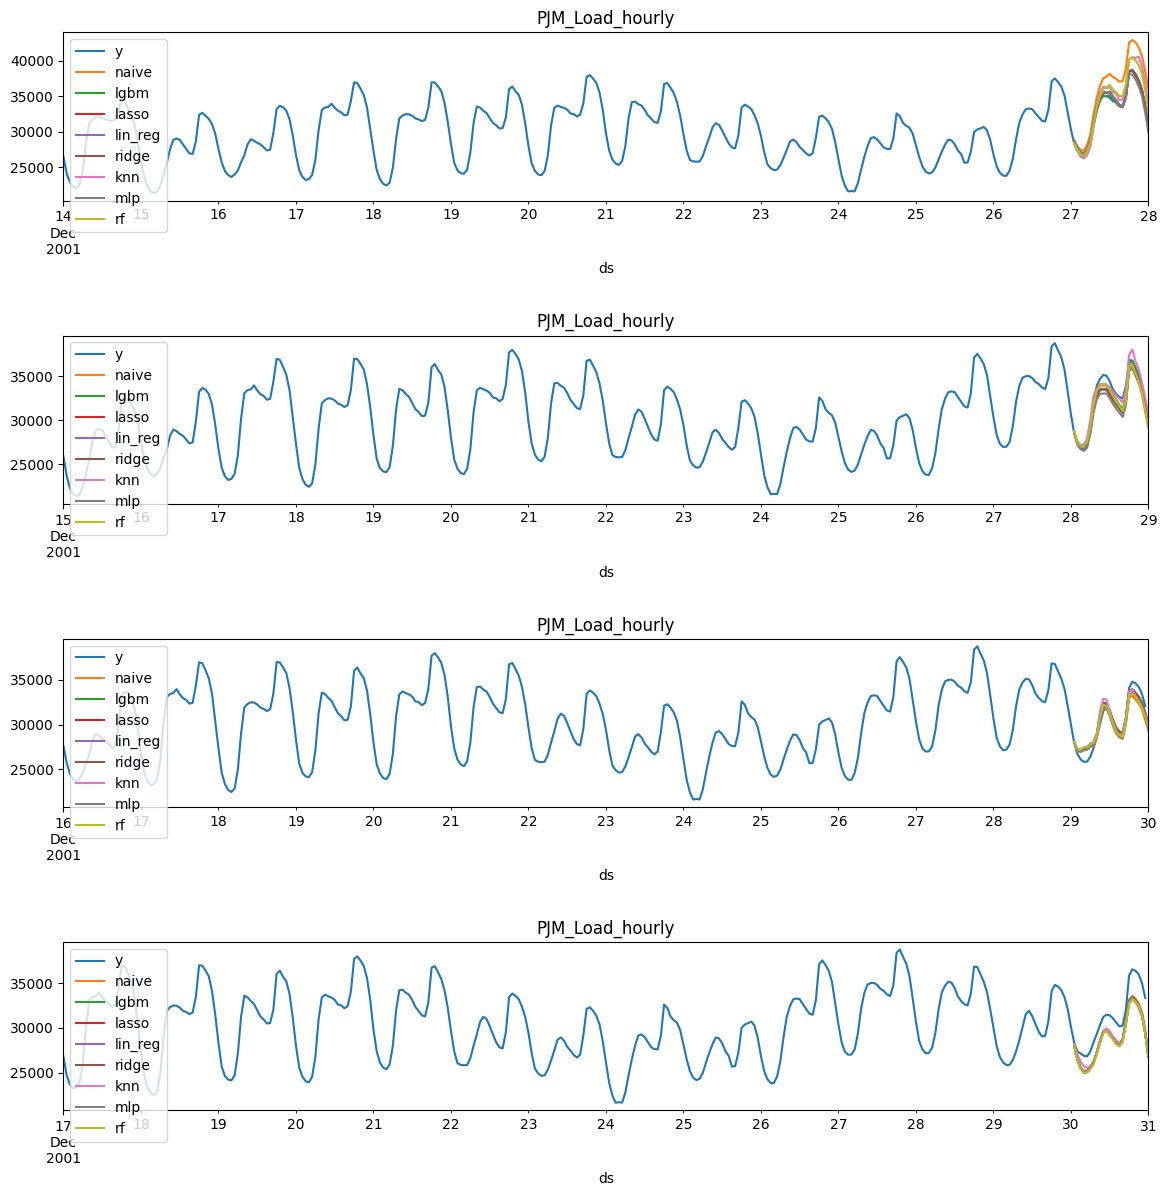

In [18]:
plot_cv(df_train, crossvalidation_df, 'PJM_Load_hourly', 'load_forecasting__predictions.png', models=models)

Visually examining the forecasts can give us some idea of how the model is behaving, yet in order to asses the performace we need to evaluate them trough metrics. For that we use the [utilsforecast](https://nixtla.github.io/utilsforecast/) library that contains many useful metrics and an evaluate function.

In [19]:
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

In [20]:
# Metrics to be used for evaluation
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape
    ]

In [21]:
# Function to evaluate the crossvalidation
def evaluate_crossvalidation(crossvalidation_df, metrics, models):
    evaluations = []
    for c in crossvalidation_df['cutoff'].unique():
        df_cv = crossvalidation_df.query('cutoff == @c')
        evaluation = evaluate(
            df = df_cv,
            metrics=metrics,
            models=list(models.keys())
            )
        evaluations.append(evaluation)
    evaluations = pd.concat(evaluations, ignore_index=True).drop(columns='unique_id')
    evaluations = evaluations.groupby('metric').mean()
    return evaluations.style.background_gradient(axis=0)


In [22]:
evaluate_crossvalidation(crossvalidation_df, metrics, models)    

,naive,lgbm,lasso,lin_reg,ridge,knn,mlp,rf
metric,,,,,,,,
mae,1631.395833,980.633935,1003.798692,1008.114908,1008.114857,1235.885417,1176.641920,1268.647083
mape,0.049759,0.031192,0.031761,0.031892,0.031892,0.038306,0.036874,0.039436
mse,4447801.625000,1954146.142817,1871606.614695,1890032.407198,1890032.193246,2560802.583750,2297613.538534,2532860.223173
rmse,1871.398919,1141.697620,1148.608054,1153.345435,1153.345380,1444.568909,1314.218092,1436.821663
smape,0.024786,0.016023,0.016269,0.016340,0.016340,0.019343,0.018951,0.020056


We can se that the model `lgbm` has top performance in most metrics folowed by the `lasso regression`. Both models perform way better than the `naive`.

### Test Evaluation

Now we are going to  evaluate their perfonce in the test set. We can use both of them for forecasting the test alongside some prediction intervals. For that we can use the [`PredictionIntervals`](https://nixtla.github.io/mlforecast/utils.html#predictionintervals) function in `mlforecast.utils`.  
You can see an in-depth tutotorial of [Probabilistic Forecasting here](https://nixtla.github.io/mlforecast/docs/prediction_intervals.html)

In [23]:
from mlforecast.utils import PredictionIntervals

In [24]:
models_evaluation ={
        'lgbm': lgb.LGBMRegressor(),
        'lasso': Lasso(),
    }

mlf_evaluation = MLForecast(
    models = models_evaluation, 
    freq='H',  # our series have hourly frequency 
    target_transforms=[Differences([24, 24*7])],
    lags=[1,12,24], 
    lag_transforms={  
        1: [expanding_mean],
        24: [(rolling_mean, 48)],
    },
    date_features=['month', 'hour', 'dayofweek']
)


Now we’re ready to generate the point forecasts and the prediction intervals. To do this, we’ll use the `fit` method, which takes the following arguments:

+ `df`: Series data in long format.
+ `id_col`: Column that identifies each series. In our case, unique_id.
+ `time_col`: Column that identifies each timestep, its values can be timestamps or integers. In our case, ds.
+ `target_col`: Column that contains the target. In our case, y.

The `PredictionIntervals` function is used to compute prediction intervals for the models using [Conformal Prediction](https://valeman.medium.com/how-to-predict-full-probability-distribution-using-machine-learning-conformal-predictive-f8f4d805e420). The function takes the following arguments:
+ `n_windows`: represents the number of cross-validation windows used to calibrate the intervals 
+ `h`: the forecast horizon  

In [25]:
mlf_evaluation.fit(
    df = df_train,
    prediction_intervals=PredictionIntervals(n_windows=4, h=24)
)

MLForecast(models=[lgbm, lasso], freq=<Hour>, lag_features=['lag1', 'lag12', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=['month', 'hour', 'dayofweek'], num_threads=1)

Now that the model has been trained we are going to forecast the next 24 hours using the `predict` method so we can compare them to our `test` data. Additionally, we are going to create prediction intervals at `levels` `[90,95]`. 

In [26]:
levels = [90, 95] # Levels for prediction intervals
forecasts = mlf_evaluation.predict(24, level=levels)
forecasts.head()

,unique_id,ds,lgbm,lasso,lgbm-lo-95,lgbm-lo-90,lgbm-hi-90,lgbm-hi-95,lasso-lo-95,lasso-lo-90,lasso-hi-90,lasso-hi-95
0,PJM_Load_hourly,2001-12-31 01:00:00,28847.573176,29124.085976,28544.593464,28567.603130,29127.543222,29150.552888,28762.752269,28772.604275,29475.567677,29485.419682
1,PJM_Load_hourly,2001-12-31 02:00:00,27862.589195,28365.330749,27042.311414,27128.839888,28596.338503,28682.866977,27528.548959,27619.065224,29111.596275,29202.112539
2,PJM_Load_hourly,2001-12-31 03:00:00,27044.418960,27712.161676,25596.659896,25688.230426,28400.607493,28492.178023,26236.955369,26338.087102,29086.236251,29187.367984
3,PJM_Load_hourly,2001-12-31 04:00:00,26976.104125,27661.572733,25249.961527,25286.024722,28666.183529,28702.246724,25911.133521,25959.815715,29363.329750,29412.011944
4,PJM_Load_hourly,2001-12-31 05:00:00,26694.246238,27393.922370,25044.220845,25051.548832,28336.943644,28344.271631,25751.547897,25762.524815,29025.319924,29036.296843


The `predict` method returns a DataFrame witht the predictions for each model (`lasso` and `lgbm`) along side the prediction tresholds. The high-threshold is indicated by the keyword `hi`, the low-threshold by the keyword `lo`, and the level by the number in the column names. 

In [27]:
test = df_last_24_hours.merge(forecasts, how='left', on=['unique_id', 'ds'])
test.head()

,unique_id,ds,y,lgbm,lasso,lgbm-lo-95,lgbm-lo-90,lgbm-hi-90,lgbm-hi-95,lasso-lo-95,lasso-lo-90,lasso-hi-90,lasso-hi-95
0,PJM_Load_hourly,2001-12-31 01:00:00,29001.0,28847.573176,29124.085976,28544.593464,28567.603130,29127.543222,29150.552888,28762.752269,28772.604275,29475.567677,29485.419682
1,PJM_Load_hourly,2001-12-31 02:00:00,28138.0,27862.589195,28365.330749,27042.311414,27128.839888,28596.338503,28682.866977,27528.548959,27619.065224,29111.596275,29202.112539
2,PJM_Load_hourly,2001-12-31 03:00:00,27830.0,27044.418960,27712.161676,25596.659896,25688.230426,28400.607493,28492.178023,26236.955369,26338.087102,29086.236251,29187.367984
3,PJM_Load_hourly,2001-12-31 04:00:00,27874.0,26976.104125,27661.572733,25249.961527,25286.024722,28666.183529,28702.246724,25911.133521,25959.815715,29363.329750,29412.011944
4,PJM_Load_hourly,2001-12-31 05:00:00,28427.0,26694.246238,27393.922370,25044.220845,25051.548832,28336.943644,28344.271631,25751.547897,25762.524815,29025.319924,29036.296843


Now we can evaluate the metrics and performance in the `test` set.

In [28]:
evaluate(
            df = test,
            metrics=metrics,
            models=list(models_evaluation.keys())
            )

,unique_id,metric,lgbm,lasso
0,PJM_Load_hourly,mae,1.092051e+03,8.999797e+02
0,PJM_Load_hourly,mse,1.796733e+06,1.354187e+06
0,PJM_Load_hourly,rmse,1.340423e+03,1.163696e+03
0,PJM_Load_hourly,mape,3.359977e-02,2.768753e-02
0,PJM_Load_hourly,smape,1.713674e-02,1.381246e-02


We can see that the `lasso` regression performed slighty better than the `LightGBM` for the test set. Additonally, we can also plot the forecasts alongside their prediction intervals. For that we can use the `plot_series` method available in  `utilsforecast.plotting`.

In [29]:
from utilsforecast.plotting import plot_series

We can plot one or many models at once alongside their coinfidence intervals.

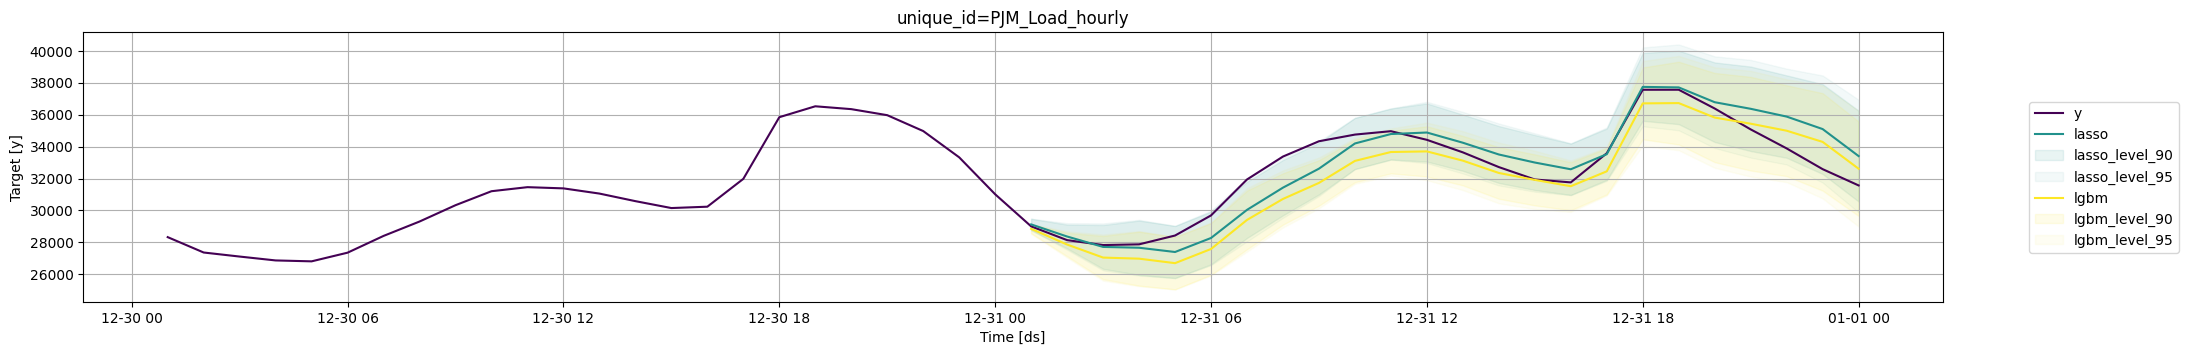

In [30]:
fig = plot_series(
    df_train, 
    test, 
    models=['lasso', 'lgbm'],
    plot_random=False, 
    level=levels, 
    max_insample_length=24
)
fig.savefig(f'../figs/load_forecasting__prediction_intervals.png', bbox_inches='tight')
fig

### Comparison with Prophet

One of the most widely used models for time series forecasting is `Prophet`. This model is known for its ability to model different seasonalities (weekly, daily yearly). We will use this model as a benchmark to see if the `lgbm` alongside `MLForecast` adds value for this time series. 

In [31]:
# Disable cmdstanpy logging
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

from prophet import Prophet
from time import time

# create prophet model
prophet = Prophet(interval_width=0.9)
init = time()
prophet.fit(df_train)
# produce forecasts
future = prophet.make_future_dataframe(periods=len(df_last_24_hours), freq='H', include_history=False)
forecast_prophet = prophet.predict(future)
end = time()
# data wrangling
forecast_prophet = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_prophet.columns = ['ds', 'Prophet', 'Prophet-lo-90', 'Prophet-hi-90']
forecast_prophet.insert(0, 'unique_id', 'PJM_Load_hourly')
forecast_prophet.head()

,unique_id,ds,Prophet,Prophet-lo-90,Prophet-hi-90
0,PJM_Load_hourly,2001-12-31 01:00:00,25333.448442,20285.760466,30272.882117
1,PJM_Load_hourly,2001-12-31 02:00:00,24039.925936,19201.303230,28946.393428
2,PJM_Load_hourly,2001-12-31 03:00:00,23363.998793,18718.566289,28089.792932
3,PJM_Load_hourly,2001-12-31 04:00:00,23371.799609,18441.181146,28082.382758
4,PJM_Load_hourly,2001-12-31 05:00:00,24146.468610,19276.003765,29271.002421


In [32]:
time_prophet = (end - init) 
print(f'Prophet Time: {time_prophet:.2f} seconds')

Prophet Time: 10.67 seconds


In [33]:
models_comparison ={
        'lgbm': lgb.LGBMRegressor()
    }

mlf_comparison = MLForecast(
    models = models_comparison, 
    freq='H',  # our series have hourly frequency 
    target_transforms=[Differences([24, 24*7])],
    lags=[1,12,24],
    lag_transforms={  
        1: [expanding_mean],
        24: [(rolling_mean, 48)],
    },
    date_features=['month', 'hour', 'dayofweek']
)

init = time()
mlf_comparison.fit(
    df_train,
    prediction_intervals=PredictionIntervals(n_windows=4, window_size=24)
)

levels = [90]
forecasts_comparison = mlf_comparison.predict(24, level=levels)
end = time()
forecasts_comparison.head()

,unique_id,ds,lgbm,lgbm-lo-90,lgbm-hi-90
0,PJM_Load_hourly,2001-12-31 01:00:00,28847.573176,28567.603130,29127.543222
1,PJM_Load_hourly,2001-12-31 02:00:00,27862.589195,27128.839888,28596.338503
2,PJM_Load_hourly,2001-12-31 03:00:00,27044.418960,25688.230426,28400.607493
3,PJM_Load_hourly,2001-12-31 04:00:00,26976.104125,25286.024722,28666.183529
4,PJM_Load_hourly,2001-12-31 05:00:00,26694.246238,25051.548832,28336.943644


In [34]:
time_lgbm = (end - init)
print(f'LGBM Time: {time_lgbm:.2f} seconds')

LGBM Time: 1.38 seconds


In [35]:
metrics_comparison = df_last_24_hours.merge(forecasts_comparison, how='left', on=['unique_id', 'ds']).merge(
    forecast_prophet, how='left', on=['unique_id', 'ds'])
metrics_comparison = evaluate(
            df = metrics_comparison,
            metrics=metrics,
            models=['Prophet', 'lgbm']
            )
metrics_comparison['improvement'] = metrics_comparison['Prophet'] /  metrics_comparison['lgbm']
metrics_comparison.reset_index(drop=True).style.background_gradient(axis=0)

,unique_id,metric,Prophet,lgbm,improvement
0,PJM_Load_hourly,mae,2266.561642,1092.050817,2.075509
1,PJM_Load_hourly,mse,7297036.705545,1796733.180360,4.061280
2,PJM_Load_hourly,rmse,2701.302779,1340.422762,2.015262
3,PJM_Load_hourly,mape,0.073226,0.033600,2.179348
4,PJM_Load_hourly,smape,0.038320,0.017137,2.236117


In [36]:
print(f'lgbm with MLForecast has a speedup of {time_prophet/time_lgbm:.2f} compared with prophet')

lgbm with MLForecast has a speedup of 7.74 compared with prophet


We can see that `lgbm` with `MLForecast` was able to provide metrics at least twice as good as `Prophet` as seen in the column `improvement` above, and way faster.